In [11]:
%reload_ext autoreload

import os
import sys
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [29]:

import text_recognizer.data
import text_recognizer.models

from text_recognizer.metadata.iam_paragraphs import IMAGE_HEIGHT, IMAGE_WIDTH


### IAM Paragraphs dataset

In [16]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
x, y = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0245), tensor(0.0795), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

<S>For without the vision to serve the Lord your God with all
your heart and with all your soul and with all your might
the problem of life cannot be solved. "Therefore shall 1ye lay
up these my words in your heart and in your soul." The text
adds and in your soul, searching your soul.<E>


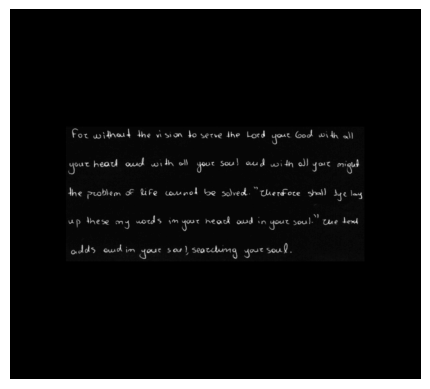

In [33]:
def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(x))

print(show(y[idx]))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### ResNet Transformer

In [21]:
rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())

In [22]:
# Cast to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnt.to(device); x = x.to(device); y = y.to(device);

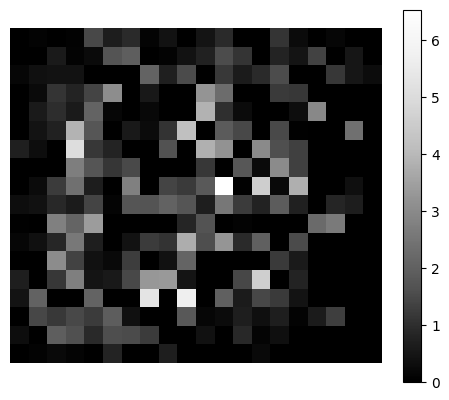

In [24]:
# Pass single input through encoder

# ResNet is designed for RGB images, replicate the input across channels 3 times
resnet_embedding, = rnt.resnet(x[idx:idx+1].repeat(1, 3, 1, 1))

resnet_idx = random.randint(0, len(resnet_embedding))  # re-execute to view a different channel
plt.matshow(resnet_embedding[resnet_idx].detach().cpu(), cmap="Greys_r");
plt.axis("off"); plt.colorbar(fraction=0.05);

In [27]:
preds, = rnt(x[idx:idx+1])

<S>d/ddNGddYrdaddVdVdVENdNVdVdddddhhddNrdVddddhdddNdddNdddVdYdVNdNVFVdVddVddNVddNdF/ddGdddddEdYYddNYddGddddFadVdbdddddddNdahdddddd?dNNVdFdNNd?dddaadhddddddhdhdVddE#dVdddddNVdhdYrVdNddNgddNdVYdhddddEdVddVVddVddddNGddNddddddddd/dVddNddddddVFdVddVddddNdgVdVddddaVVddddNNNVddaVhddddNdddVddVdNVdrddEYdVdddVdddddbddrdVddaFFdVddddVdddVdrddddddVdddardhddddNdddVrdNEhVddhrdZdVNdddVVhddddddddNddddhNdVddrhdNdEddhdddrdddNddVrVddddVdddVddddNVdddddddddddrdddddrdddhhddddVNdNddddGddddddd//rGddVddNddErhGYFFdNaEFddddrddhYdF3NdhV+dddEdddddVhddddhhddddddgddVdddrrVhddNdadNddddddN/dddNGddaNNdEdrbdVdNNddddddddhdddVNdFdNdhNddVd4ddddVddNdddddEdEdVFddVraVddGVdddFdddVFdNdVVErddddNVdddddGFVVhNNNddYdddddddd


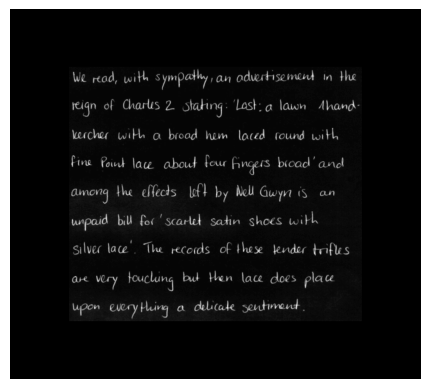

In [32]:
# Prediction from untrained model
print(show(preds.cpu()))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

In [ ]:
import text_recognizer.lit_models

lit_rnt = text_recognizer.lit_models.TransformerLitModel(rnt)